# Paso 1. Planteamiento del Problema

Se desea predecir los precios de propiedades publicadas en Airbnb en vecindarios de NYC.

**Obtención de Datos**

In [1]:
#Descargamos los datos
import requests
import os

url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
filename = os.path.basename(url)

save_dir = os.path.join(os.path.pardir, "data", "raw")
save_path = os.path.join(save_dir, filename)

os.makedirs(os.path.dirname(save_path), exist_ok=True)

response = requests.get(url)
with open(save_path, 'wb') as f:
    f.write(response.content)

print(f"Archivo guardado en: {save_path}")

Archivo guardado en: ../data/raw/AB_NYC_2019.csv


In [2]:
#Cargar el dataset
import pandas as pd

# Ruta relativa al archivo desde src/
csv_path = os.path.join(os.path.pardir, "data", "raw", "AB_NYC_2019.csv")

# Cargar el dataset en una variable (DataFrame)
total_data = pd.read_csv(csv_path)

# Paso 2. Exploración y Limpieza de Datos

In [3]:
#Obtener Dimensiones
print(total_data.shape)

#Obtener Información sobre los tipos de datos
print(total_data.info())

(48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review         

Hay un total de 48895 filas (que corresponden a las propiedades) y 15 columnas, entre las cuales se encuentra la clase a predecir, *price*.

Algunas variables tienen instancias con valores nulos: *name* tiene 16 filas con valores nulos, *host_name* tiene 21 filas con valores nulos, *last_review* y *reviews_per_month* tienen 10052 filas con valores nulos (sobre el 20%).

El conjunto de datos tiene 10 variables numéricas y 5 variables categóricas.

**Eliminar Duplicados**

Verificamos si existen duplicados usando el *id*, pero además *latitude* y *longitude*, puesto que una misma propiedad podría estar dos veces en el listado con diferentes ids.

In [4]:
total_data.drop("id", axis = 1).duplicated().sum()

np.int64(0)

In [5]:
total_data.drop(["latitude", "longitude"], axis = 1).duplicated().sum()

np.int64(0)

Dado que no hay propiedades duplicadas, no necesitamos eliminar filas.

**Eliminar Información Irrelevante**

Eliminamos aquellas variables del dataset que no aportan información relevante al análisis. Esto seria cualquier dato que identifica a la propiedad o al propietario.

In [6]:
total_data.drop(["id", "name", "host_id", "host_name"], axis = 1, inplace = True)
total_data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Las columnas que nos quedan en el dataset son:

- *neighbourhood_group*: grupo de vecindario, categórica
- *neighbourhood*: vecindario, categórica
- *latitude*: latitud, numérica
- *longitude*: longitud, numérica
- *room_type*: tipo de publicación, categórica
- *price*: precio por noche, numérica (variable objetivo)
- *minimun_nights*: cantidad mínima de noches que pueden reservarse, numérica
- *number_of_reviews*: cantidad de reseñas que tiene la propiedad, numérica
- *last_review*: fecha de la última reseña, temporal/numérica
- *reviews_per_month*: cantidad promedio de reseñas por mes, numérica
- *calculated_host_listings_count*: cantidad de propiedades que tiene el propietario, numérica
- *availability_365*: cantidad de días en los que la propiedad está disponible anualmente, numérica

# Paso 3. Análisis Univariante

Hacemos un análisis de las variables que quedan en el dataset. Para ello, graficaremos histogramas, boxplots, diagramas de barras y diagramas de dispersión.

**Variables Categóricas**

- *neighbourhood_group*

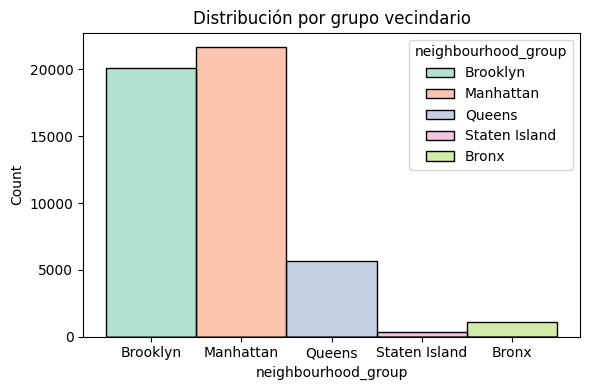

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns

#neighbourhood_group
plt.figure(figsize=(6, 4))
sns.histplot(data=total_data, x="neighbourhood_group", hue="neighbourhood_group", palette="Set2")
plt.title("Distribución por grupo vecindario")
plt.tight_layout()
plt.show()

El histograma de la variable *neighborhood_group* nos muestra cómo se distribuyen las propiedades entre los vecindarios estudiados. La cantidad de propiedades entre Brooklyn y Manhattan es bastante similar. También puede observarse que hay muchas menos propiedades en Queens, Staten Island y el Bronx que en los vecindarios anteriores.

- *neighbourhood*

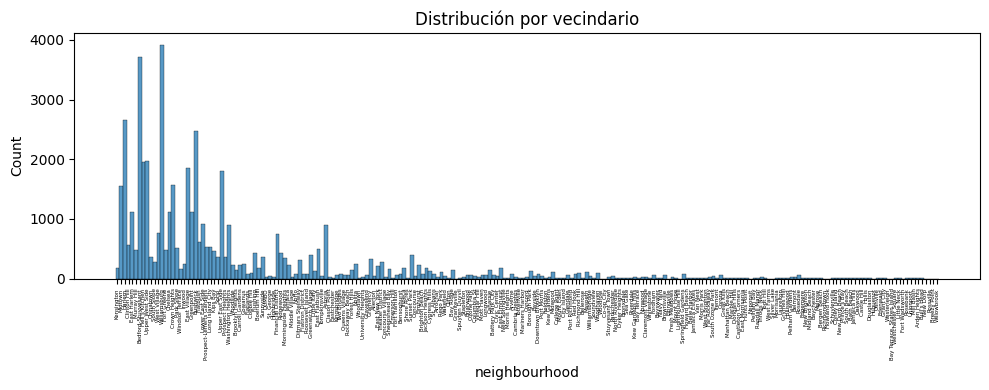

In [8]:
#Neighbourhood Total
plt.figure(figsize=(10, 4))
ax = sns.histplot(data=total_data, x="neighbourhood")
ax.tick_params(axis='x', rotation=90, labelsize=4)
plt.title("Distribución por vecindario")
plt.tight_layout()
plt.show()

Visualizar la distribución de los *neighborhood_group* es un poco más complicado debido a la cantidad de valores diferentes. Para facilitar el análisis, filtraremos por aquellos valores que tengan menos de 100 ocurrencias en el dataset.

In [9]:
#Creamos tres variables filtrando los vecindarios en función al número de propiedades
neighbourhood_counts = total_data['neighbourhood'].value_counts()

neighbourhood_over_100 = neighbourhood_counts[neighbourhood_counts > 100].index
neighbourhood_under_100_over_50 = neighbourhood_counts[(neighbourhood_counts <= 100) & (neighbourhood_counts > 50)].index
neighbourhood_under_50 = neighbourhood_counts[neighbourhood_counts <= 50].index

filtered_over_100 = total_data[total_data['neighbourhood'].isin(neighbourhood_over_100)]
filtered_under_100_over_50 = total_data[total_data['neighbourhood'].isin(neighbourhood_under_100_over_50)]
filtered_under_50 = total_data[total_data['neighbourhood'].isin(neighbourhood_under_50)]

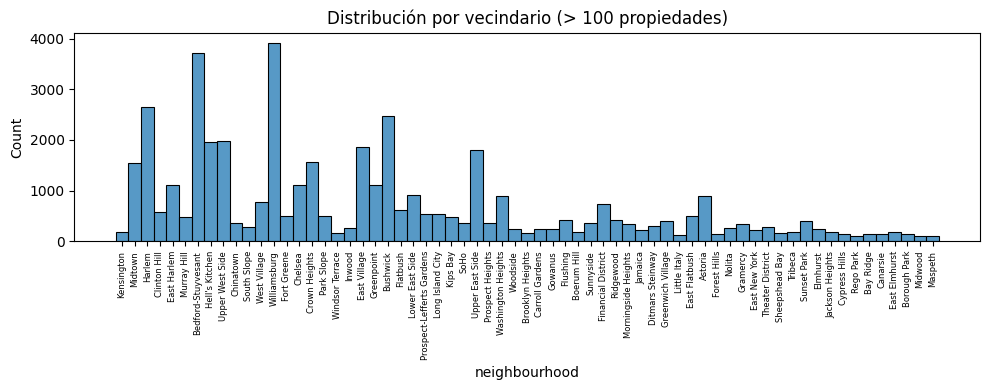

In [10]:
#Neighbourhood > 100
plt.figure(figsize=(10, 4))
sns.histplot(data=filtered_over_100, x="neighbourhood")
plt.xticks(rotation=90, fontsize=6)
plt.title("Distribución por vecindario (> 100 propiedades)")
plt.tight_layout()
plt.show()

De los vecindarios que tienen más de 100 propiedades, Williamsbourg es el que mayor cantidad de propiedades (cerca de 4000), seguido de Bedford-Stuyvesant (cerca de 3800). Le sigue Harlem con menos de 3000 propiedades.

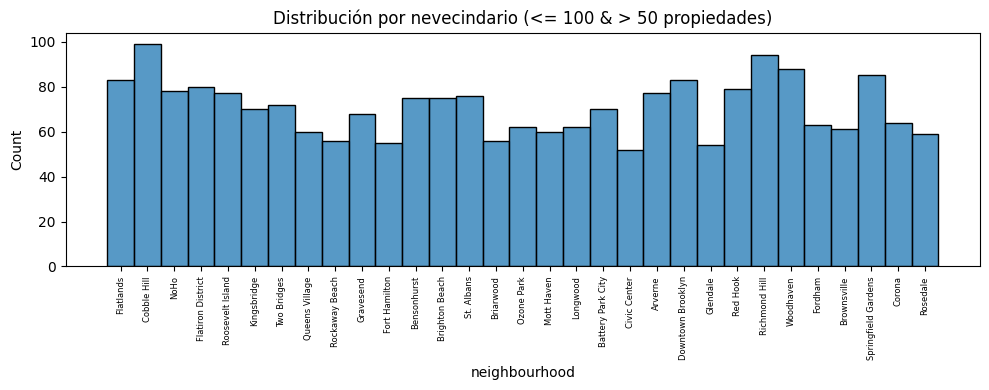

In [11]:
#Neighbourhood <= 100 & > 50
plt.figure(figsize=(10, 4))
sns.histplot(data=filtered_under_100_over_50, x="neighbourhood")
plt.xticks(rotation=90, fontsize=6)
plt.title("Distribución por nevecindario (<= 100 & > 50 propiedades)")
plt.tight_layout()
plt.show()

La lista de vecindarios que tienen entre 51 y 100 propiedades está encabezada por Cobble Hill, seguida por Richmond Hill y Woodhaven.

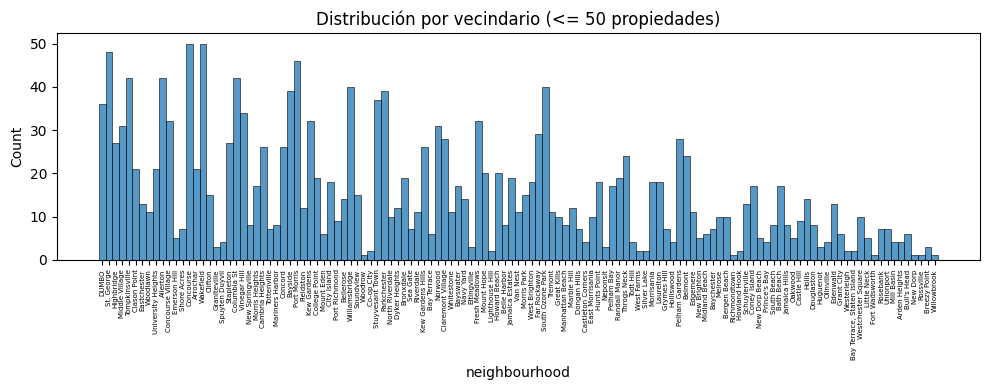

In [12]:
#Neighbourhood <= 50
plt.figure(figsize=(10, 4))
sns.histplot(data=filtered_under_50, x="neighbourhood")
plt.xticks(rotation=90, fontsize=5)
plt.title("Distribución por vecindario (<= 50 propiedades)")
plt.tight_layout()
plt.show()

Finalmente, la lista de vecindarios que tienen hasta 50 propiedades está encabezada por Concourse y Arrochar, seguidos por St. George.

Este análisis nos permite ver que hay más vecindarios con menos de 50 propiedades (125 en total), que vecindarios con entre 51 y 100 propiedades (31 en total) y vecindarios con más de 100 propiedades (65 en total).

- *room_type*

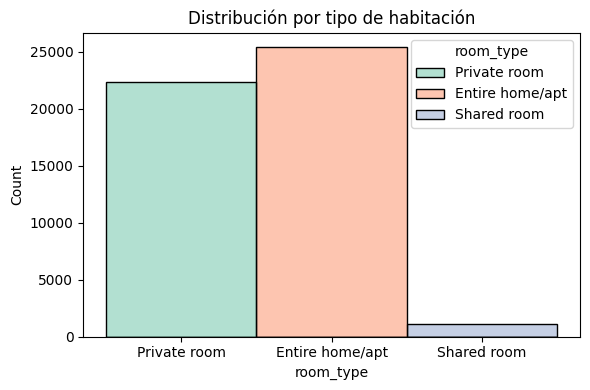

In [13]:
#neighbourhood_group
plt.figure(figsize=(6, 4))
sns.histplot(data=total_data, x="room_type", hue="room_type", palette="Set2")
plt.title("Distribución por tipo de habitación")
plt.tight_layout()
plt.show()

**Variables Numéricas**

- *price*

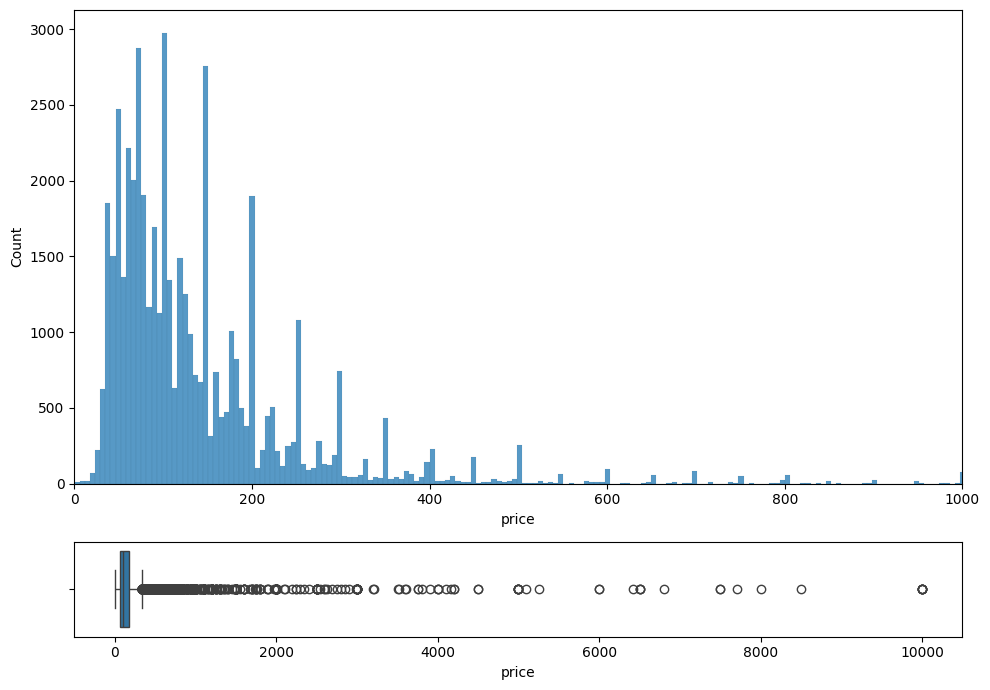

In [14]:
#Precio de la propiedad
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "price").set_xlim(0, 1000)
sns.boxplot(ax = axis[1], data = total_data, x = "price")

plt.tight_layout()

plt.show()

Tanto el histograma como el boxplot indican que los precios de las propiedades oscilan entre 0 y 10.000. Esta información no se visualiza en el histograma pues la dispersión de los datos no permitiría visualizar correctamente los valores. El boxplot nos muestra valores atípicos cuando el precio supera más o menos los $350. Un histograma mostrando únicamente los valores no considerados atípicos se vería como sigue:

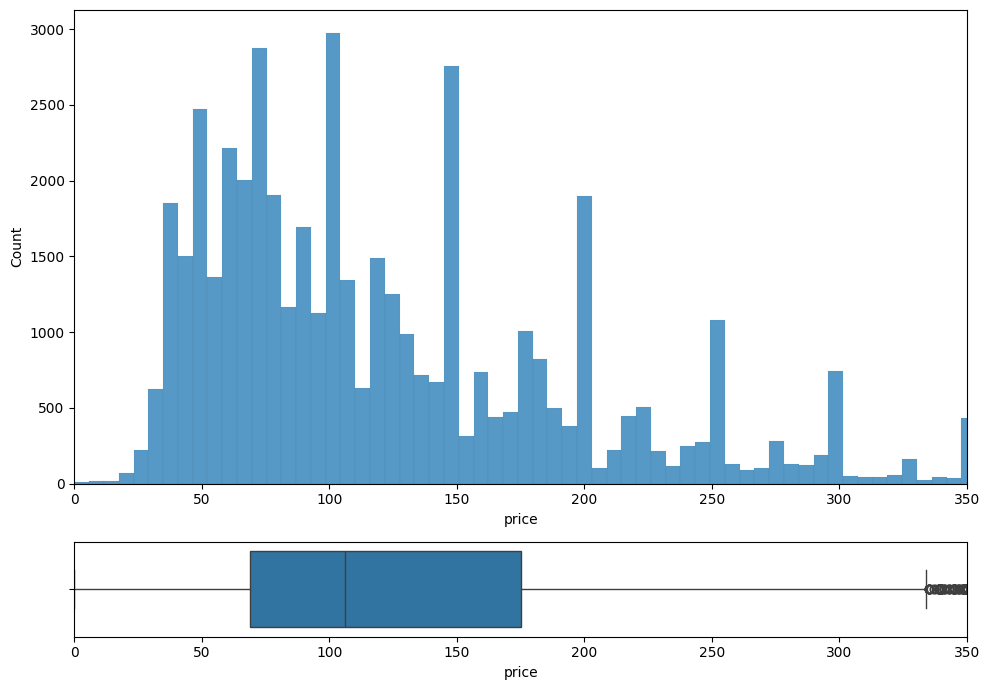

In [15]:
#Precio de la propiedad
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "price").set_xlim(0, 350)
sns.boxplot(ax = axis[1], data = total_data, x = "price").set_xlim(0, 350)

plt.tight_layout()

plt.show()

También puede observarse que la mediana de los datos está sobre los $100.

- *minimum_nights*

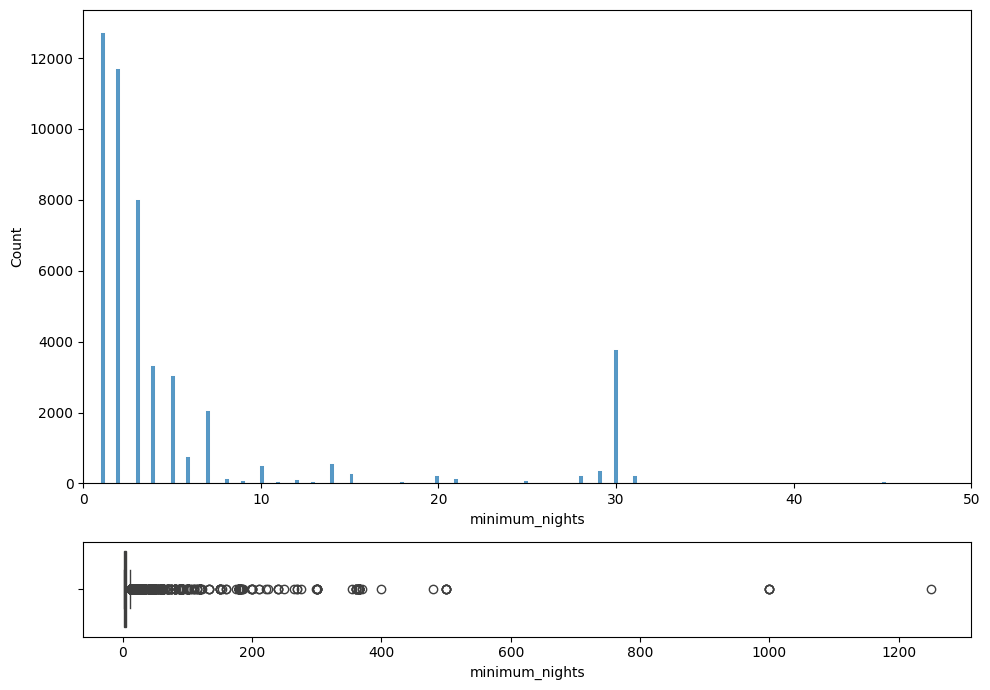

In [16]:
#Mínimo de Noches
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "minimum_nights").set_xlim(0, 50)
sns.boxplot(ax = axis[1], data = total_data, x = "minimum_nights")

plt.tight_layout()

plt.show()

Para visualizar mejor los datos, se limitó el histograma para mostrar los datos de 0 a 50. El boxplot muestra que hay una cantidad importante de datos atípicos, con datos en las 1000 y sobre 1200 cantidad mínima de noches.

La mayoría de las propiedades permiten como mínimo entre 1 y 3 noches, con algunas propiedades limitando a un mínimo de 30 noches.

Si se quiere visualizar mejor a partir de qué cantidad de noches los datos son considerados atípicos, ajustamos el eje x del diagrama de cajas:

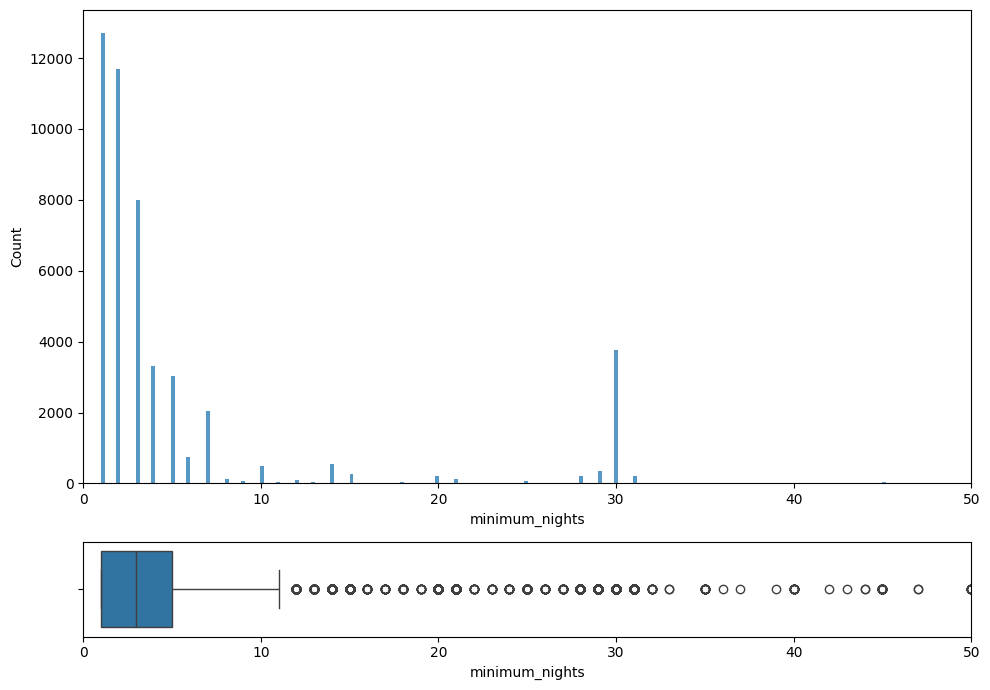

In [17]:
#Mínimo de Noches
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "minimum_nights").set_xlim(0, 50)
sns.boxplot(ax = axis[1], data = total_data, x = "minimum_nights").set_xlim(0, 50)

plt.tight_layout()

plt.show()

El boxplot obtenido ajustando la escala de los datos muestra que más de 11 noches de estancia mínima es considerado un outlier.

- *number_of_reviews*

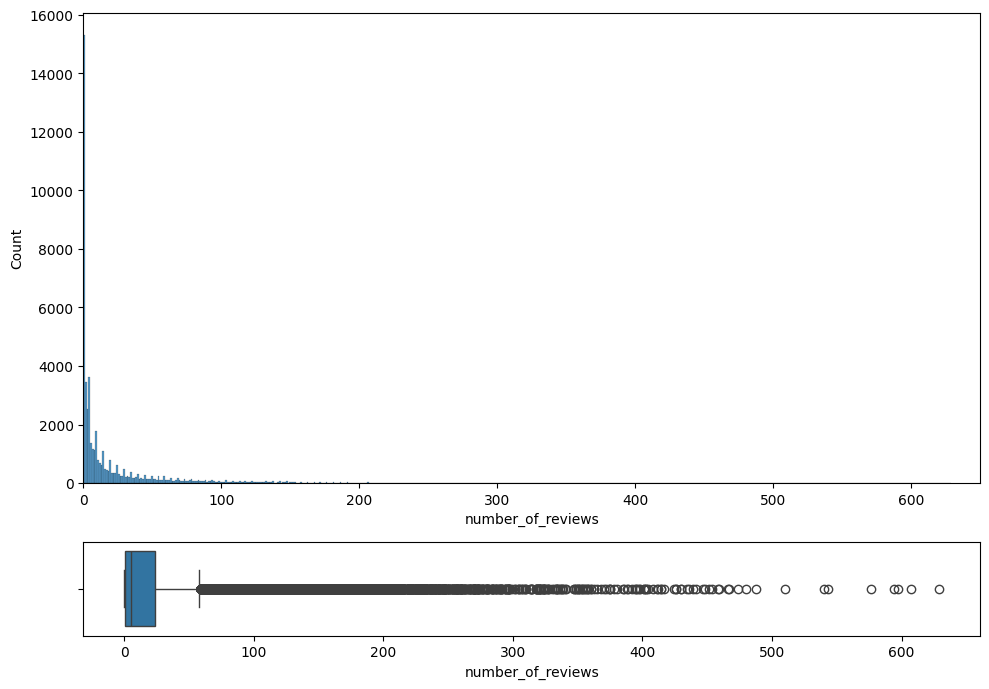

In [18]:
#Número de Reseñas
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "number_of_reviews").set_xlim(0, 650)
sns.boxplot(ax = axis[1], data = total_data, x = "number_of_reviews")

plt.tight_layout()

plt.show()

Tanto en el histograma como en el boxplot podemos ver que el minimo de reviews que tienen algunas propiedades es 0 y que las propiedades que más reviews tienen, tienen más de 600. El boxplot nos muestra valores atípicos cuando se superan aproximadamente los 60 reviews. Un histograma mostrando únicamente los valores no considerados atípicos se vería como sigue:

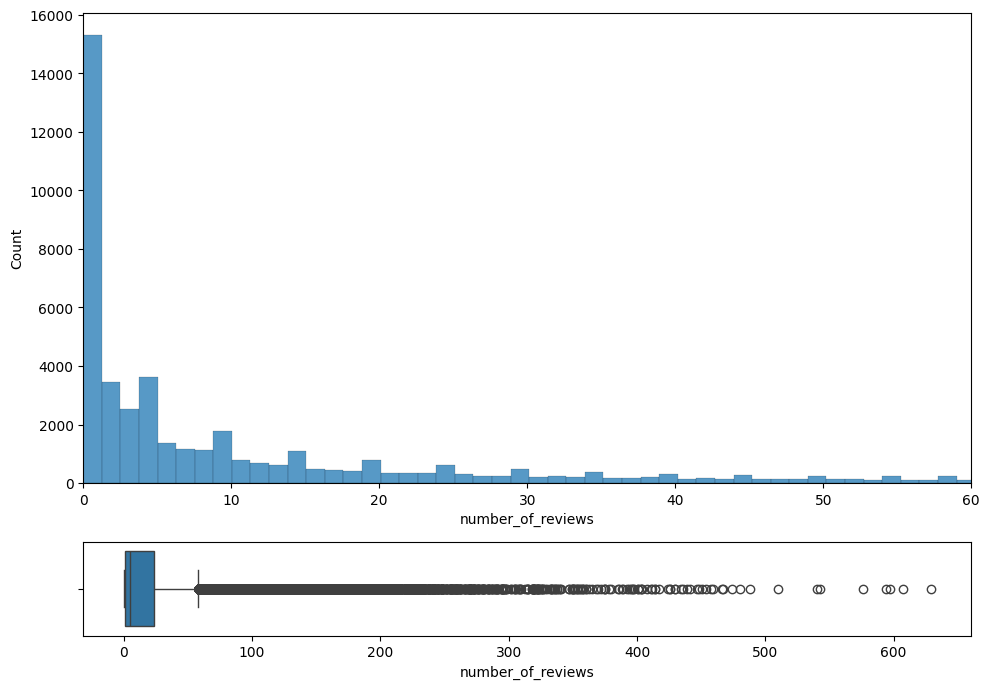

In [19]:
#Número de Reseñas
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "number_of_reviews").set_xlim(0, 60)
sns.boxplot(ax = axis[1], data = total_data, x = "number_of_reviews")

plt.tight_layout()

plt.show()

La mayoría de las propiedades no tienen reviews y, la mayoría de las propiedades tiene menos de 10 reviews. El boxplot muestra que los datos se dispersan más a la derecha de la mediana.

- *reviews_ per_month*

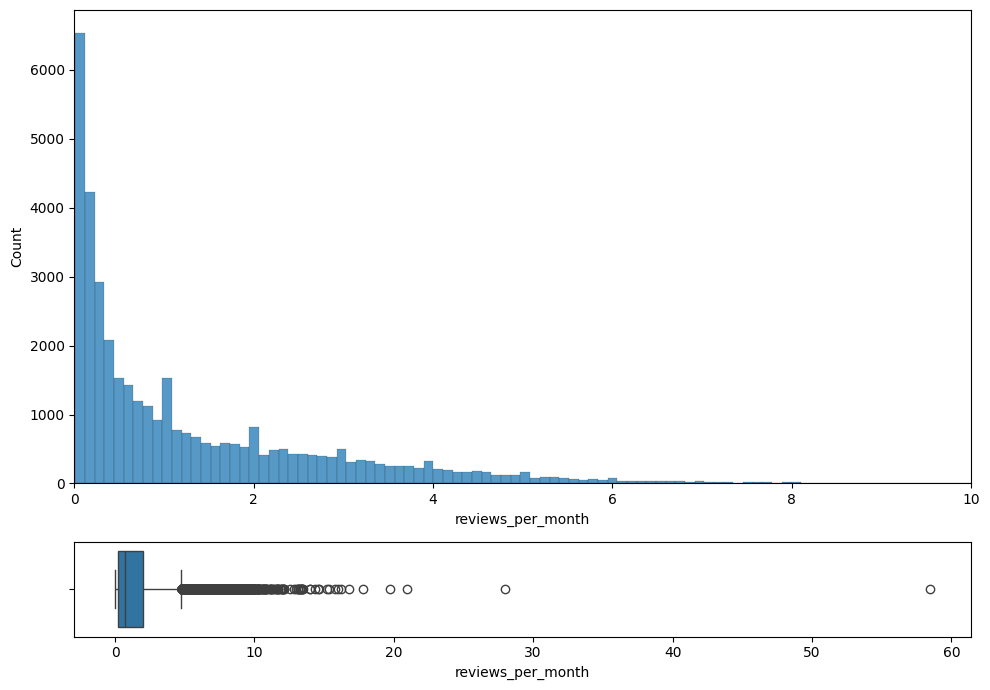

In [20]:
#Reseñas por mes
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "reviews_per_month").set_xlim(0, 10)
sns.boxplot(ax = axis[1], data = total_data, x = "reviews_per_month")

plt.tight_layout()

plt.show()

Se pude ver que más de 6000 propiedades no tienen reseñas por mes y que la máxima cantidad de reseñas que una propiedad ha tenido en un mes está cerca de 60.
El boxplot también muestra que más de 5 reseñas por mes es considerado un outlier.

- *calculated_host_listings_count*

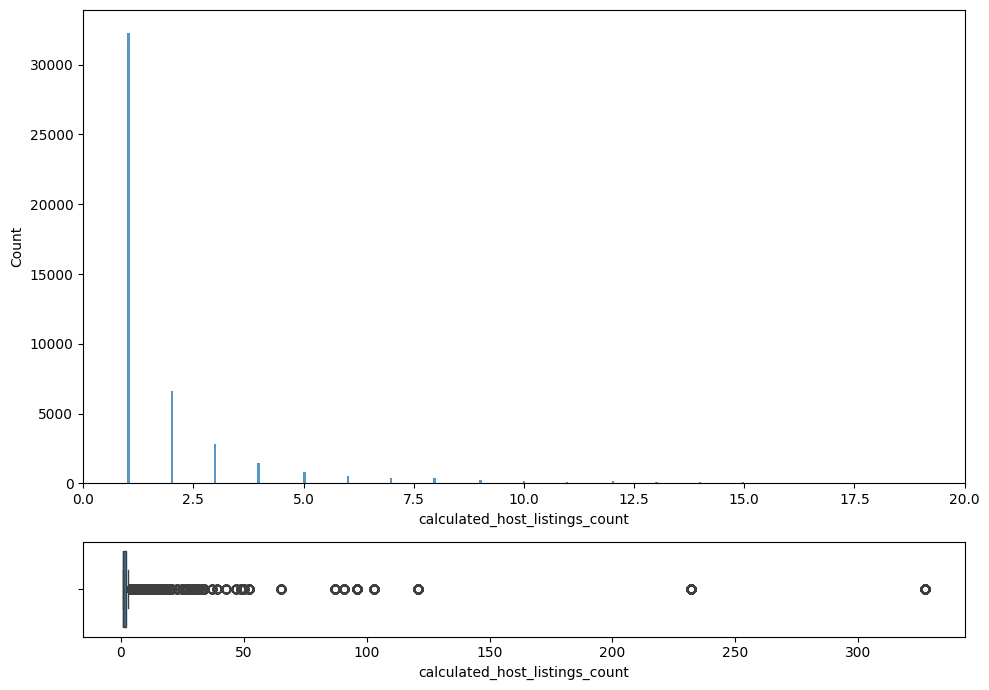

In [21]:
#Cantidad de propiedades del mismo anfitrión
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "calculated_host_listings_count").set_xlim(0, 20)
sns.boxplot(ax = axis[1], data = total_data, x = "calculated_host_listings_count")

plt.tight_layout()

plt.show()

El histograma y el boxplot muestran que la mayoría de los anfitriones tiene una única propiedad en Airbnb y que hay anfitriones con más de 300 propiedades publicadas. Ajustando el eje X para visualizar mejor los gráficos:

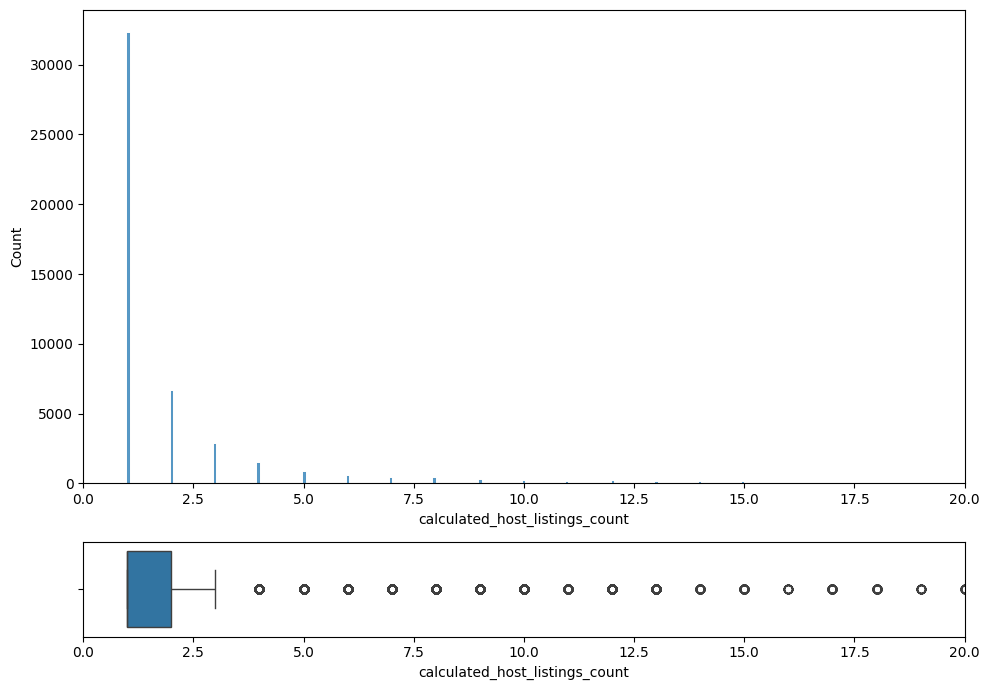

In [22]:
#Cantidad de propiedades del mismo anfitrión
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "calculated_host_listings_count").set_xlim(0, 20)
sns.boxplot(ax = axis[1], data = total_data, x = "calculated_host_listings_count").set_xlim(0, 20)

plt.tight_layout()

plt.show()

Limitando los datos observados, a partir de 3 propiedades, se considera un outlier.

- *availability_365*

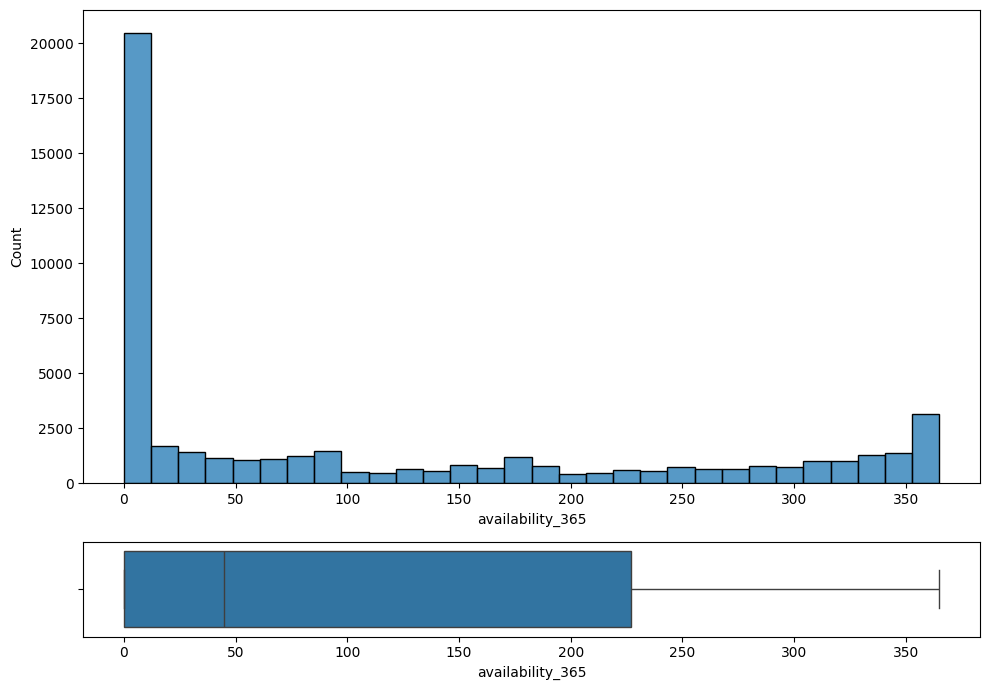

In [23]:
#Noches disponibles en un año
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "availability_365")
sns.boxplot(ax = axis[1], data = total_data, x = "availability_365")

plt.tight_layout()

plt.show()

La mayoría de las propiedades dice tener una disponibilidad de 0 noches. El máximo es de 365 noches y ningún valor se considera atípico. El boxplot muestra que los datos están más dispersos a la derecha de la mediana.

- *latitude*

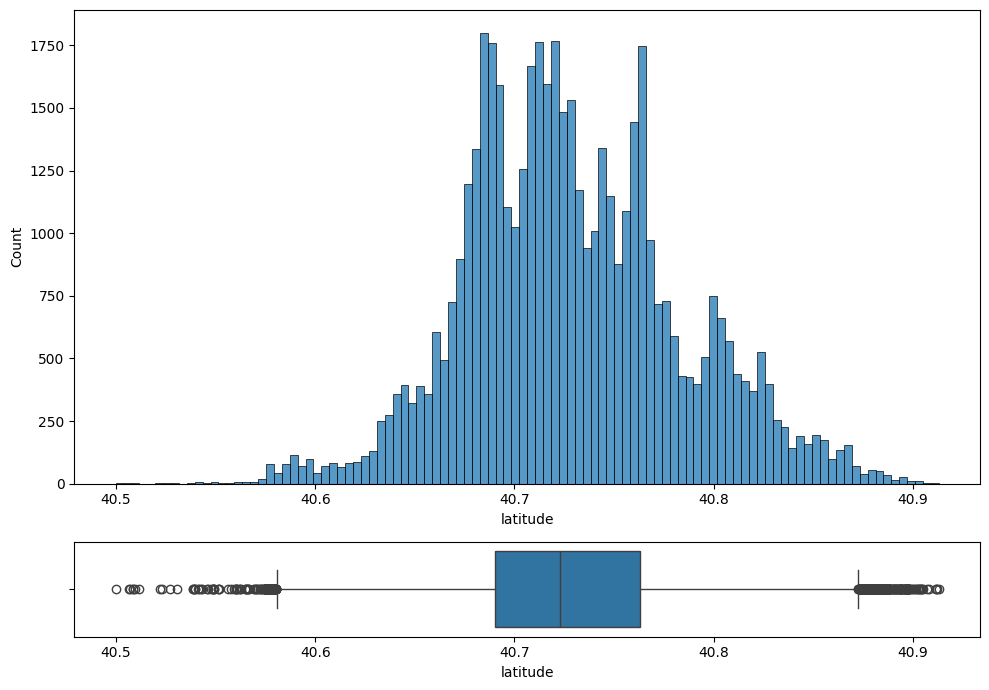

In [24]:
#Latitud
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "latitude")
sns.boxplot(ax = axis[1], data = total_data, x = "latitude")

plt.tight_layout()

plt.show()

El histograma de la latitud nos muestra que hay tres modas en los datos. Eso significa que la mayoría de las propiedades publicadas se encuentran ubicadas a esa altura. El boxplot de los datos nos muestra que se consideran valores atípicos aquellos inferiores a 40.6 y aquellos que están llegando a 40.9. La dispersión de los datos es bastante similar tanto a la izquierda como a la derecha de la mediana.

- *longitude*

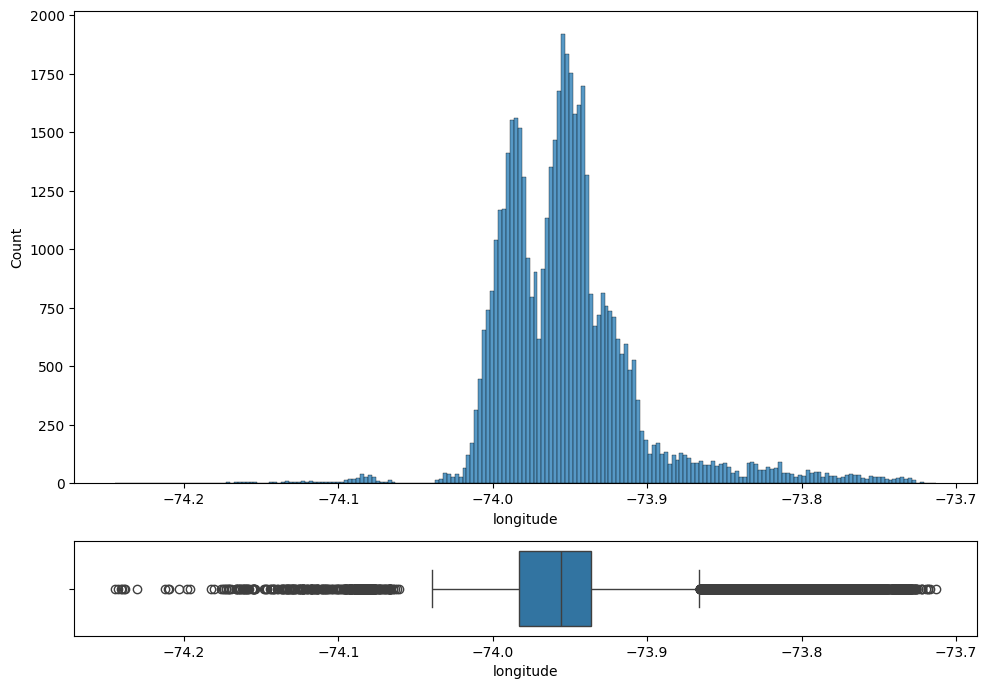

In [25]:
#Longitud
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "longitude")
sns.boxplot(ax = axis[1], data = total_data, x = "longitude")

plt.tight_layout()

plt.show()

El histograma de la longitud nos muestra que hay dos modas en los datos. Eso significa que la mayoría de las propiedades publicadas se encuentran en esos dos puntos geográficos. El boxplot de los datos nos muestra que se consideran valores atípicos aquellos inferiores a -74.0 y superiores a -73.9. La dispersión de los datos es bastante similar tanto a la izquierda como a la derecha de la mediana.

- *last_review*

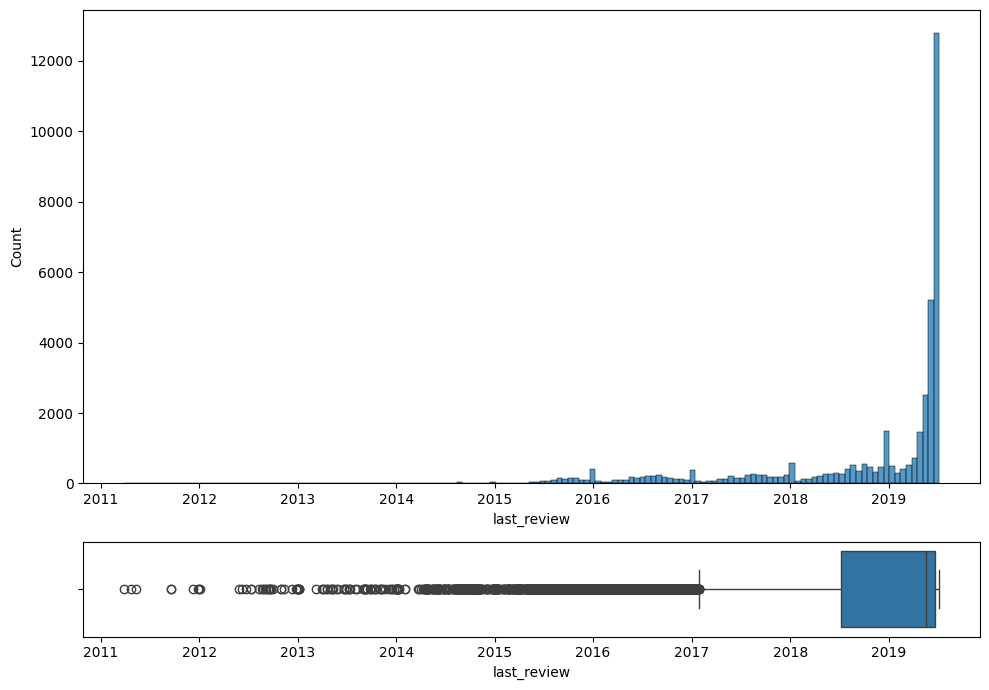

In [26]:
#Last Review
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

total_data["last_review"] = pd.to_datetime(total_data["last_review"]) 

today = pd.Timestamp.today()
total_data["days_since_last_review"] = (today - total_data["last_review"]).dt.days

sns.histplot(ax = axis[0], data = total_data, x = "last_review")
sns.boxplot(ax = axis[1], data = total_data, x = "last_review")

plt.tight_layout()

plt.show()

Para el análisis de la variable last_review, llevamos la variable a formato datetime. Luego, graficamos el histograma y boxplot de los datos.

Podemos observar que hay propiedades que recibieron su última reseña en 2011 y aquellas cuya última reseña fueron antes de 2017 son consideradas atípicas. La dispersión de los datos es mayor a la izquierda de la mediana.

- **days_since_last_review**

Para facilitar posibles análisis posteriores, creamos una nueva variable con los días desde la última reseña. De este modo, podremos trabajar con una variable numérica en lugar de una fecha.

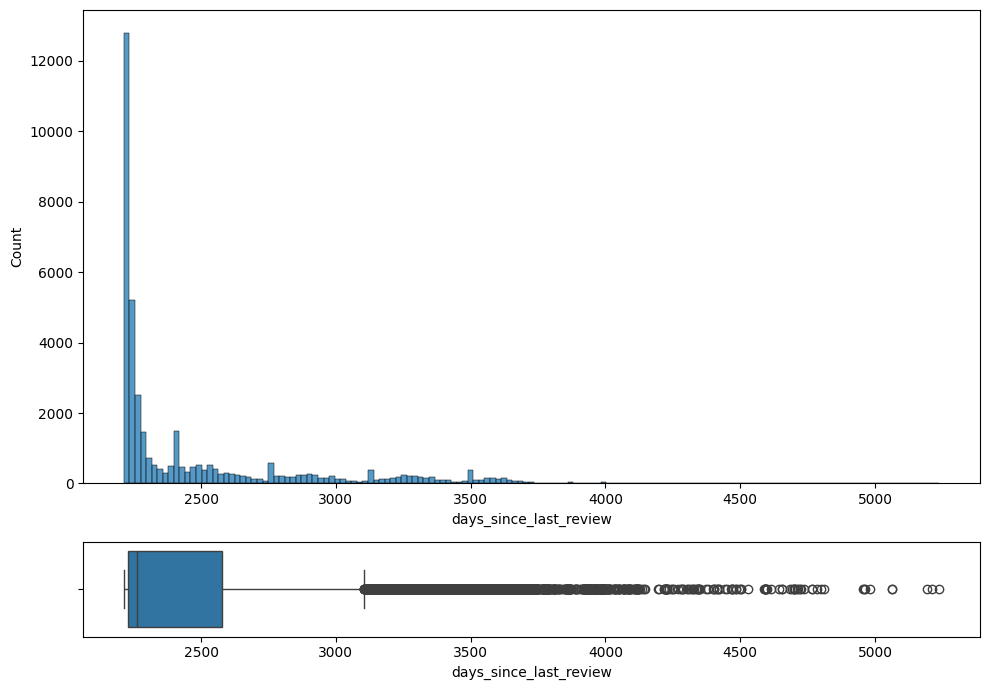

In [27]:
#Days Since Last Review
fig, axis = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [5, 1]})

sns.histplot(ax = axis[0], data = total_data, x = "days_since_last_review")
sns.boxplot(ax = axis[1], data = total_data, x = "days_since_last_review")

plt.tight_layout()

plt.show()

Tanto el histograma como el boxplot de la nueva variable son un espejo de la variable last_review (esto se debe a que al transformar la variable, los gráficos se invierten).

# Paso 4. Análisis Multivariante

Haremos un análisis de cada variable con la variable objetivo y con ellas mismas para sacar conclusiones más claras acerca de sus relaciones y poder tomar decisiones sobre su procesamiento.

**Análisis Numérico - Numérico**

price - (minimum_nights, calculated_host_listings_count, number_of_reviews, availability_365, latitude, longitude)

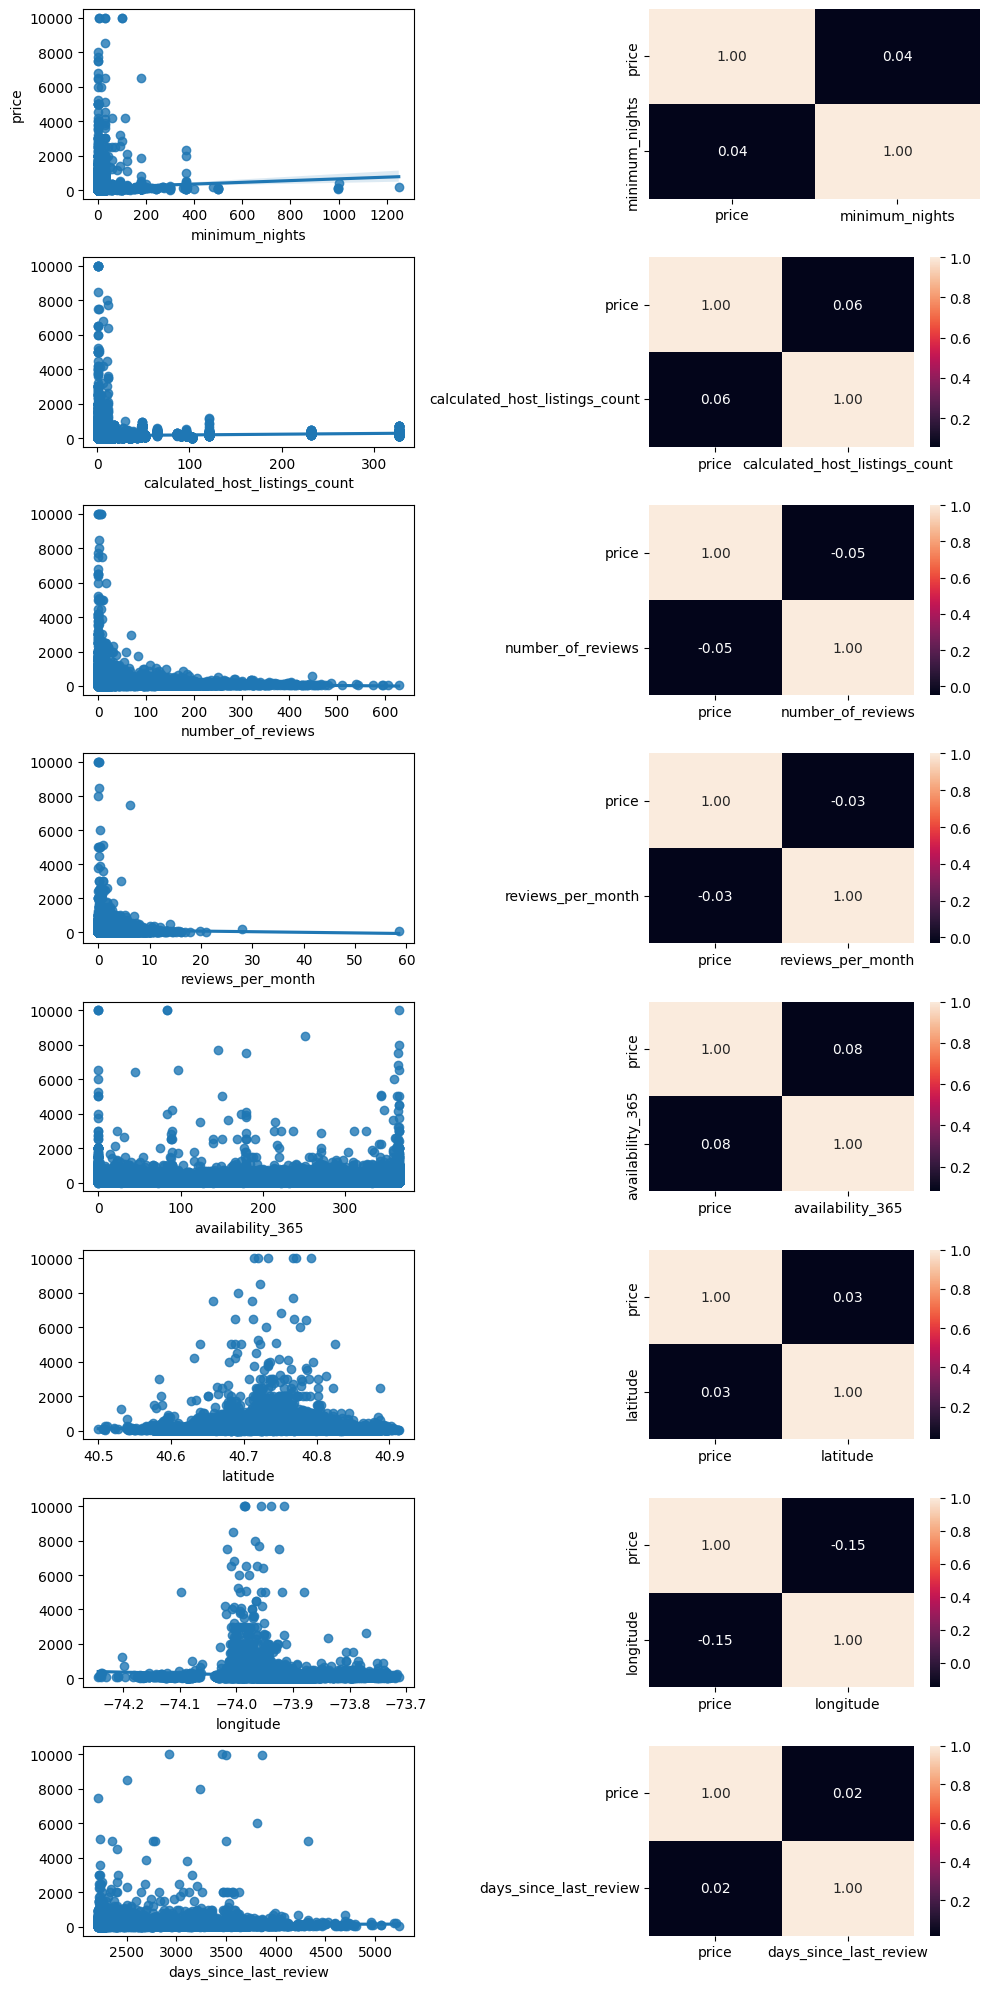

In [28]:
fig, axis = plt.subplots(8, 2, figsize = (10, 20))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "minimum_nights", y = "price")
sns.heatmap(total_data[["price", "minimum_nights"]].corr(), annot = True, fmt = ".2f", ax = axis[0, 1], cbar = False)
sns.regplot(ax = axis[1, 0], data = total_data, x = "calculated_host_listings_count", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "calculated_host_listings_count"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])
sns.regplot(ax = axis[2, 0], data = total_data, x = "number_of_reviews", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "number_of_reviews"]].corr(), annot = True, fmt = ".2f", ax = axis[2, 1])
sns.regplot(ax = axis[3, 0], data = total_data, x = "reviews_per_month", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "reviews_per_month"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 1])
sns.regplot(ax = axis[4, 0], data = total_data, x = "availability_365", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "availability_365"]].corr(), annot = True, fmt = ".2f", ax = axis[4, 1])
sns.regplot(ax = axis[5, 0], data = total_data, x = "latitude", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "latitude"]].corr(), annot = True, fmt = ".2f", ax = axis[5, 1])
sns.regplot(ax = axis[6, 0], data = total_data, x = "longitude", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "longitude"]].corr(), annot = True, fmt = ".2f", ax = axis[6, 1])
sns.regplot(ax = axis[7, 0], data = total_data, x = "days_since_last_review", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "days_since_last_review"]].corr(), annot = True, fmt = ".2f", ax = axis[7, 1])


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

- *minimum_nights*: Existe una relación linel positiva entre el precio por noche de la propiedad y la cantidad mínima de noches durante las que ésta se puede reservar.
- *calculated_host_listings_count*: Existe una relación linel positiva entre el precio por noche de la propiedad y la cantidad de propiedades que tiene un anfitrión.
- *number_of_reviews*: Existe una relación linel negativa muy pequeña entre la cantidad de reseñas que tiene una propiedad y su precio por noche.
- *reviews_per_month*: Existe una relación linel negativa muy pequeña entre la cantidad de reseñas mensuales promedio que tiene una propiedad y su precio por noche.
- *availability_365*: Existe una relación linel positiva muy pequeña entre el precio por noche de la propiedad y la cantidad de días al año en los que está disponible.
- *latitude*: Existe una relación linel positiva mínima entre la latitud geográfica de la propiedad y el precio por noche de la propiedad.
- *longitude*: Existe una relación linel negativa entre el precio por noche de la propiedad y la longitud geográfica de la propiedad.
- *days_since_last_review*: Existe una relación linel positiva mínima entre la fecha de la última reseña y el precio por noche de la propiedad.

Para continuar con el análisis de las variables categóricas y poder hacer un gráfico de correlaciones, debemos transformar estas variables en variables numéricas.

In [29]:
total_data["neighbourhood_n"] = pd.factorize(total_data["neighbourhood"])[0]
total_data["neighbourhood_group_n"] = pd.factorize(total_data["neighbourhood_group"])[0]
total_data["room_type_n"] = pd.factorize(total_data["room_type"])[0]

Tras haber transformado las variables categóricas a variables numéricas, procedemos a hacer el análisis de correlaciones para determinar si afectan a la variable objetivo.

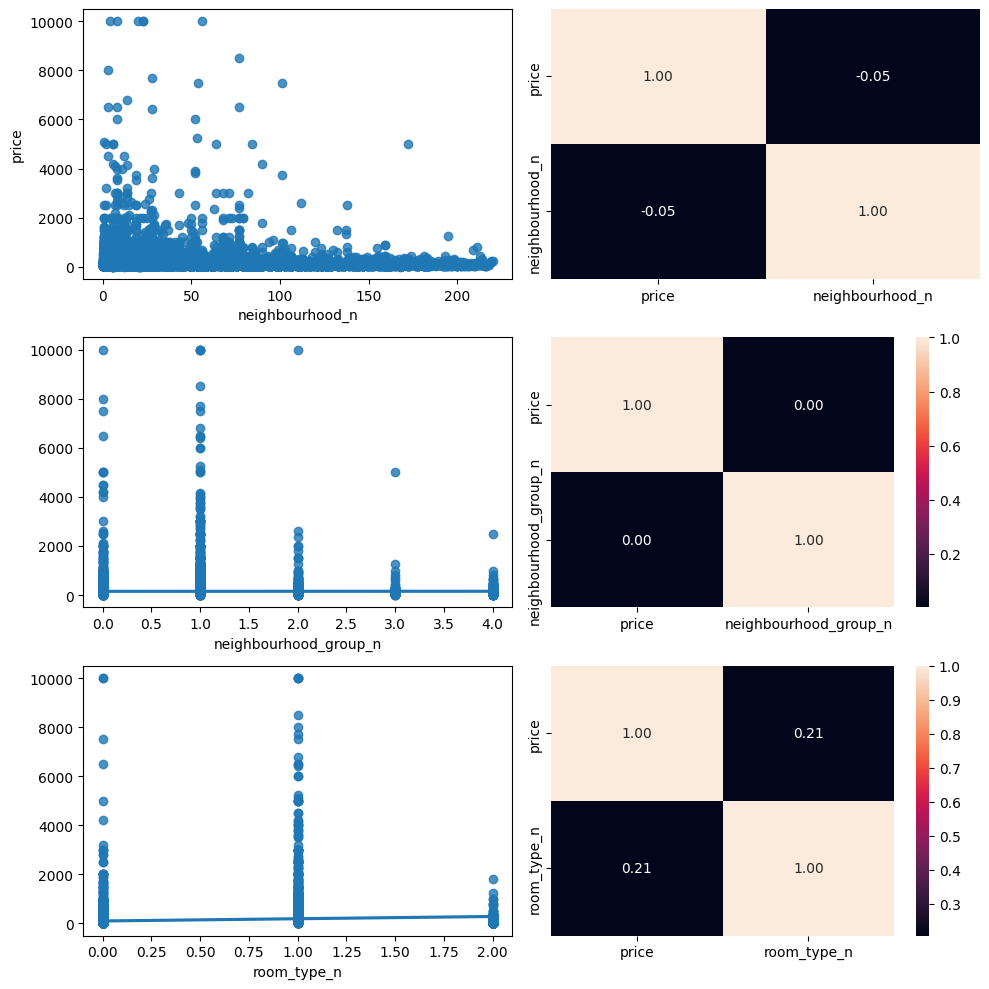

In [30]:
fig, axis = plt.subplots(3, 2, figsize = (10, 10))

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_data, x = "neighbourhood_n", y = "price")
sns.heatmap(total_data[["price", "neighbourhood_n"]].corr(), annot = True, fmt = ".2f", ax = axis[0, 1], cbar = False)
sns.regplot(ax = axis[1, 0], data = total_data, x = "neighbourhood_group_n", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "neighbourhood_group_n"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])
sns.regplot(ax = axis[2, 0], data = total_data, x = "room_type_n", y = "price").set(ylabel=None)
sns.heatmap(total_data[["price", "room_type_n"]].corr(), annot = True, fmt = ".2f", ax = axis[2, 1])


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

- *neighbourhood_n*: Existe una relación linel negativa entre el precio por noche de la propiedad y el vecindario.
- *neighbourhood_group_n*: No parece existir correlación entre el neighbourhood_group y el precio por noche de la propiedad.
- *room_type_n*: Existe una correlación media-baja entre el tipo de propiedad y el precio por noche de la propiedad.

**Análisis de Correlación Múltiple**

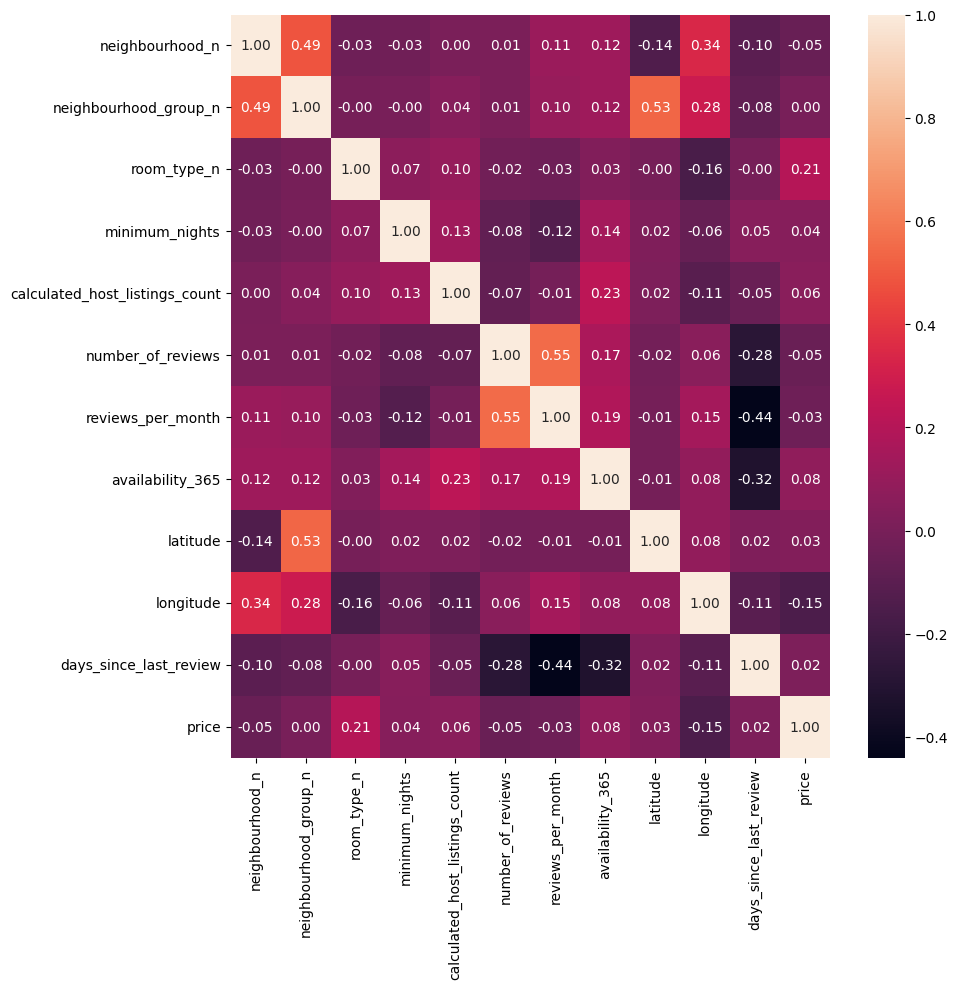

In [31]:
fig, axis = plt.subplots(figsize = (10, 10))

sns.heatmap(total_data[["neighbourhood_n", "neighbourhood_group_n", "room_type_n", "minimum_nights", "calculated_host_listings_count", "number_of_reviews", "reviews_per_month", "availability_365", "latitude", "longitude", "days_since_last_review", "price"]].corr(), annot = True, fmt = ".2f")

plt.tight_layout()

plt.show()

El análisis de correlaciones refleja una fuerte relación directa entre el la latitud de la propiedad y el grupo de vecindarios, lo cual tiene sentido al tratarse de dos niveles de la  misma clasificación.

La variable con mayor correlación con el precio de la propiedad es *room_type*.

Tambien se aprecia una relación entre la longitud y el vecindario y vecindario agrupado, pues todas son variables relacionadas con la ubicación geográfica de la propiedad. Lo mismo ocurre entre latitud, vecindario y vecindario agrupado.

La correlación media-alta entre reviews y reviews_per_month tiene sentido cuando vemos una variable como el valor medio de la otra.

Otra correlación notable es la que existe entre reviews_per_month y days_since_last_review. En este caso, la correlación es negativa y esto se debe a que a mayor cantidad de días desde la última reseña, menor es el promedio de reseñas por mes.

También podemos ver que hay una correlación media entre la disponibilidad de una propiedad durante el año y la cantidad de propiedades que tiene un propietario, lo que sugiere que mientras más propiedades publicadas tiene un propietario, mayor es la disponibilidad anual de este propietario. Lo cual tiene sentido, puesto que muchas propiedades sugiere que el propietario considera airbnb como un negocio estable.

El mapa de calor sugiere también que aquellas propiedades que están disponibles durante más días en el año también son aquellas que tienen más reseñas, lo que tiene sentido porque si hay más posibilidades para reservarla, hay más posibilidades para dejar una reseña.

**Eliminar Variables**

En este punto podemos eliminar algunas variables que no parecen relevantes al análisis o que resultan redundantes. Por ejemplo, la variable neighbourhood_group, con una correlación de 0.0 con la variable objetivo, puede quedar fuera del dataset.

Adicionalmente, las variables *last_review* y *reviews_per_month* tienen cerca más de un 20% de valores nulos y una correlación muy baja, por lo que también se excluyen del dataset.

In [32]:
new_data = total_data.drop(columns=['neighbourhood_group', 'neighbourhood_group_n', 'last_review', 'reviews_per_month', 'days_since_last_review'])

# Paso 5. Ingeniería de Características

**Análisis de Outliers**

In [33]:
new_data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,7.143982,112.781327,29.888782,0.567113
std,0.054530,0.046157,240.154170,20.510550,44.550582,32.952519,131.622289,34.676634,0.541249
min,40.499790,-74.244420,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,1.000000,0.000000,7.500000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,1.000000,45.000000,19.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.000000,227.000000,37.000000,1.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,327.000000,365.000000,220.000000,2.000000


- Los valores de *latitude* y *longitude* parecen estar dentro de lo esperado, considerando que el dataset está conformado por viviendas que están ubicadas en la misma ciudad.
- Los datos para *price* muestran que el mínimo es 0 (algo no muy coherente considerando que se trata del precio por noche de alquiler de una propiedad) y un máximo de 10.000. El valor máximo es especialmente llamativo cuando se toma en cuenta que el valor en el percentil 75 es de 175.
- Los valores de *number_of_reviews* parecen razonables.
- Los valores de *calculated_host_listings_count* también tienen un máximo muy superior al 75 percentil.
- Los valores de *availability_365* parecen razonables, exceptuando aquellos en 0.
- Los valores para *neighbourhood_n* parecen razonables.
- Los valores para *room_type_n* parecen razonables.

Dibujamos el diagrama de cajas de las variables para tener más información sobre los valores atípicos.

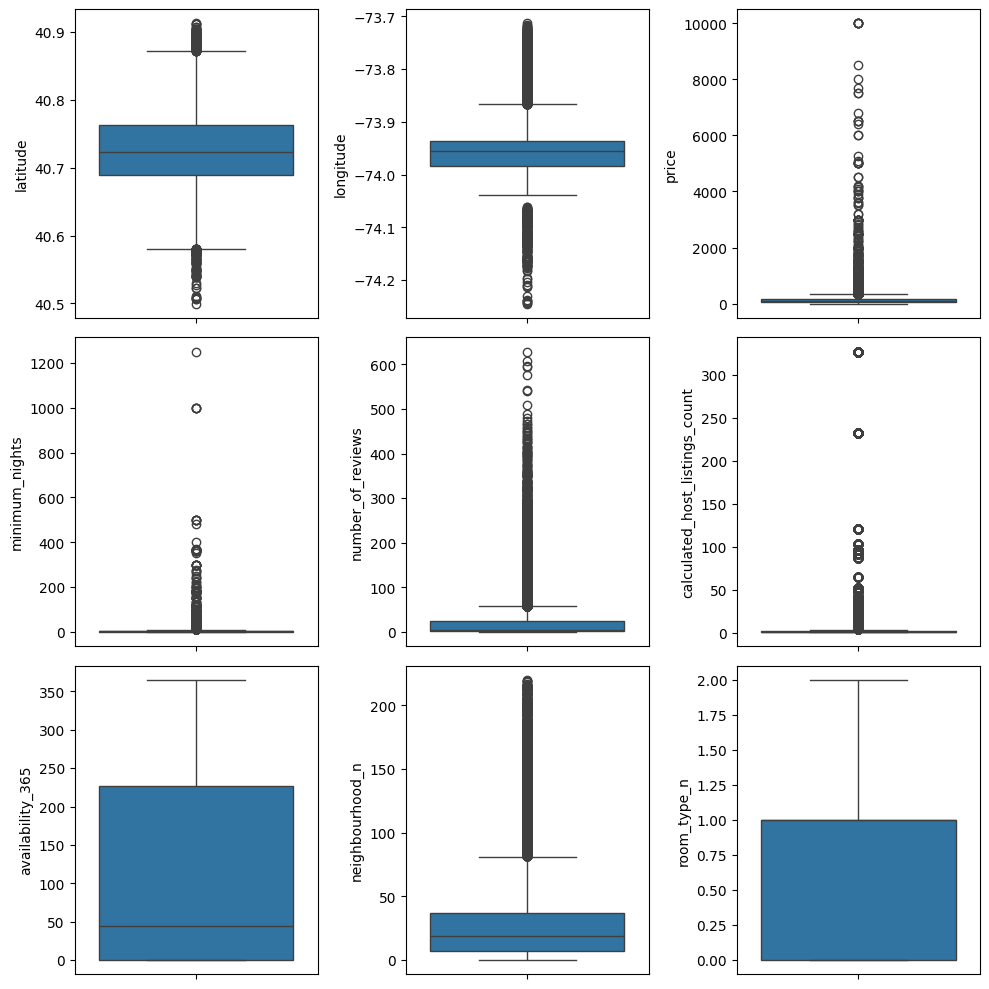

In [34]:
fig, axis = plt.subplots(3, 3, figsize = (10, 10))

sns.boxplot(ax = axis[0, 0], data = new_data, y = "latitude")
sns.boxplot(ax = axis[0, 1], data = new_data, y = "longitude")
sns.boxplot(ax = axis[0, 2], data = new_data, y = "price")
sns.boxplot(ax = axis[1, 0], data = new_data, y = "minimum_nights")
sns.boxplot(ax = axis[1, 1], data = new_data, y = "number_of_reviews")
sns.boxplot(ax = axis[1, 2], data = new_data, y = "calculated_host_listings_count")
sns.boxplot(ax = axis[2, 0], data = new_data, y = "availability_365")
sns.boxplot(ax = axis[2, 1], data = new_data, y = "neighbourhood_n")
sns.boxplot(ax = axis[2, 2], data = new_data, y = "room_type_n")

plt.tight_layout()

plt.show()

Podemos ver que todas las variables menos *availability_365* y *room_type* son afectadas por valores atípicos. En el caso de *price*, podríamos establecer puntos superior e inferior que nos permitan determinar qué datos deben considerarse atípicos.

Vamos a intentar eliminar algunos datos atípicos:
- *price*
- *minimum_nights*
- *number_of_reviews*
- *calculated_host_listings_count*

Los valores atípicos que mantendremos serán los relacionados con la ubicación geográfica de la propiedad, puesto que ser considerado atípico no deja de lado que es una propiedad real, con una ubicación real.

Para el resto de las variables, eliminaremos aquellos valores que puedan afectar a los demás datos.

Antes de eliminar los datos atípicos, guardamos los dataset.

In [35]:
new_data_CON_outliers = new_data.copy()

new_data_SIN_outliers = new_data.copy()

In [36]:
# Para cada una de las variables con outliers en mi problema, tengo que reemplazar sus valores del DF
def replace_outliers_from_column(column, df):
  column_stats = df[column].describe()
  column_iqr = column_stats["75%"] - column_stats["25%"]
  upper_limit = column_stats["75%"] + 1.5 * column_iqr
  lower_limit = column_stats["25%"] - 1.5 * column_iqr
  if lower_limit < 0: lower_limit = min(df[column])
  # Remove upper outliers
  df[column] = df[column].apply(lambda x: (x if (x <= upper_limit) else upper_limit) if not pd.isna(x) else np.nan)
  # Remove lower outliers
  df[column] = df[column].apply(lambda x: (x if (x >= lower_limit) else lower_limit) if not pd.isna(x) else np.nan)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']:
  new_data_SIN_outliers, limit_list = replace_outliers_from_column(column, new_data_SIN_outliers)
  outliers_dict[column] = limit_list

outliers_dict

{'minimum_nights': [1, np.float64(11.0)],
 'number_of_reviews': [0, np.float64(58.5)],
 'calculated_host_listings_count': [1, np.float64(3.5)]}

Luego de eliminar los valores atípicos, analizamos las medidas de dispersión de las variables del dataset:

In [37]:
new_data_SIN_outliers.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n
count,48895.000000,48895.000000,48895.000000,48895.00000,48895.00000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,3.82532,15.67419,1.614920,112.781327,29.888782,0.567113
std,0.054530,0.046157,240.154170,3.32072,20.34953,0.946883,131.622289,34.676634,0.541249
min,40.499790,-74.244420,0.000000,1.00000,0.00000,1.000000,0.000000,0.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.00000,1.00000,1.000000,0.000000,7.500000,0.000000
50%,40.723070,-73.955680,106.000000,3.00000,5.00000,1.000000,45.000000,19.000000,1.000000
75%,40.763115,-73.936275,175.000000,5.00000,24.00000,2.000000,227.000000,37.000000,1.000000
max,40.913060,-73.712990,10000.000000,11.00000,58.50000,3.500000,365.000000,220.000000,2.000000


Podemos ver que se eliminaron algunos valores que, al parecer, no tienen un impacto real sobre el precio por noche de la propiedad.

**Análisis de valores faltantes**

Dado que previamente eliminamos aquellas columnas con poca correlación y un 20% de valores faltantes, en este paso no tenemos que hacer nada.

In [38]:
new_data_SIN_outliers.isnull().sum().sort_values(ascending=False)

neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
neighbourhood_n                   0
room_type_n                       0
dtype: int64

**Inferencia de Nuevas Características**

Dos variables que sólo tienen significado cuando están juntas son *latitude* y *longitude*, así que la convertiremos en una sola variable que sea su distancia al centro de Manhattan.

In [39]:
from geopy.distance import geodesic

manhattan_center = (40.7580, -73.9855)

new_data_CON_outliers["dist_to_center"] = total_data.apply(lambda row: geodesic((row["latitude"], row["longitude"]), manhattan_center).km, axis=1)
new_data_SIN_outliers["dist_to_center"] = total_data.apply(lambda row: geodesic((row["latitude"], row["longitude"]), manhattan_center).km, axis=1)

**Escalado de Valores**

In [40]:
from sklearn.model_selection import train_test_split

num_variables = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", "availability_365", "neighbourhood_n", "room_type_n", "dist_to_center"]

# Dividimos el conjunto de datos en muestras de train y test
X_CON = new_data_CON_outliers.drop("price", axis = 1)[num_variables]
y = new_data_CON_outliers["price"]
X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 42)

X_SIN = new_data_SIN_outliers.drop("price", axis = 1)[num_variables]
X_train_sin_outliers, X_test_sin_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 42)

X_train_con_outliers.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
32645,3,11,1,1,12,1,5.338508
23615,2,2,1,0,30,0,10.813721
31183,2,0,2,0,6,0,7.872477
29260,3,87,1,267,6,1,9.386149
7275,5,13,1,0,31,0,7.685401


**Normalización**

In [41]:
from sklearn.preprocessing import StandardScaler
import pickle

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
normalizador_con_outliers = StandardScaler()
normalizador_con_outliers.fit(X_train_con_outliers)

X_train_con_outliers_norm = normalizador_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_norm = pd.DataFrame(X_train_con_outliers_norm, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_norm = normalizador_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_norm = pd.DataFrame(X_test_con_outliers_norm, index = X_test_con_outliers.index, columns = num_variables)


### NORMALIZAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
normalizador_sin_outliers = StandardScaler()
normalizador_sin_outliers.fit(X_train_sin_outliers)

X_train_sin_outliers_norm = normalizador_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_norm = pd.DataFrame(X_train_sin_outliers_norm, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_norm = normalizador_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_norm = pd.DataFrame(X_test_sin_outliers_norm, index = X_test_sin_outliers.index, columns = num_variables)

X_train_con_outliers_norm.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
32645,-0.193025,-0.277198,-0.186570,-0.852862,-0.514100,0.798949,-0.395996
23615,-0.239596,-0.479451,-0.186570,-0.860447,0.005517,-1.050482,0.836717
31183,-0.239596,-0.524396,-0.156424,-0.860447,-0.687306,-1.050482,0.174513
29260,-0.193025,1.430714,-0.186570,1.164663,-0.687306,0.798949,0.515307
7275,-0.099884,-0.232253,-0.186570,-0.860447,0.034385,-1.050482,0.132394


**Escalado Mínimo-Máximo**

In [42]:
from sklearn.preprocessing import MinMaxScaler

### NORMALIZAMOS EL DATAFRAME CON OUTLIERS Y LO GUARDAMOS
scaler_con_outliers = MinMaxScaler()
scaler_con_outliers.fit(X_train_con_outliers)

X_train_con_outliers_scal = scaler_con_outliers.transform(X_train_con_outliers)
X_train_con_outliers_scal = pd.DataFrame(X_train_con_outliers_scal, index = X_train_con_outliers.index, columns = num_variables)

X_test_con_outliers_scal = scaler_con_outliers.transform(X_test_con_outliers)
X_test_con_outliers_scal = pd.DataFrame(X_test_con_outliers_scal, index = X_test_con_outliers.index, columns = num_variables)


### ESCALAMOS EL DATAFRAME SIN OUTLIERS Y LO GUARDAMOS
scaler_sin_outliers = MinMaxScaler()
scaler_sin_outliers.fit(X_train_sin_outliers)

X_train_sin_outliers_scal = scaler_sin_outliers.transform(X_train_sin_outliers)
X_train_sin_outliers_scal = pd.DataFrame(X_train_sin_outliers_scal, index = X_train_sin_outliers.index, columns = num_variables)

X_test_sin_outliers_scal = scaler_sin_outliers.transform(X_test_sin_outliers)
X_test_sin_outliers_scal = pd.DataFrame(X_test_sin_outliers_scal, index = X_test_sin_outliers.index, columns = num_variables)

X_train_con_outliers_scal.head()


,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
32645,0.001601,0.017488,0.000000,0.002740,0.054545,0.5,0.147073
23615,0.000801,0.003180,0.000000,0.000000,0.136364,0.0,0.299875
31183,0.000801,0.000000,0.003067,0.000000,0.027273,0.0,0.217791
29260,0.001601,0.138315,0.000000,0.731507,0.027273,0.5,0.260035
7275,0.003203,0.020668,0.000000,0.000000,0.140909,0.0,0.212570


Almacenamos nuestros nuevos dataset

In [43]:
import openpyxl

X_train_con_outliers.to_excel("../data/processed/X_train_con_outliers.xlsx", index = False)
X_train_sin_outliers.to_excel("../data/processed/X_train_sin_outliers.xlsx", index = False)
X_train_con_outliers_norm.to_excel("../data/processed/X_train_con_outliers_norm.xlsx", index = False)
X_train_sin_outliers_norm.to_excel("../data/processed/X_train_sin_outliers_norm.xlsx", index = False)
X_train_con_outliers_scal.to_excel("../data/processed/X_train_con_outliers_scal.xlsx", index = False)
X_train_sin_outliers_scal.to_excel("../data/processed/X_train_sin_outliers_scal.xlsx", index = False)

X_test_con_outliers.to_excel("../data/processed/X_test_con_outliers.xlsx", index = False)
X_test_sin_outliers.to_excel("../data/processed/X_test_sin_outliers.xlsx", index = False)
X_test_con_outliers_norm.to_excel("../data/processed/X_test_con_outliers_norm.xlsx", index = False)
X_test_sin_outliers_norm.to_excel("../data/processed/X_test_sin_outliers_norm.xlsx", index = False)
X_test_con_outliers_scal.to_excel("../data/processed/X_test_con_outliers_scal.xlsx", index = False)
X_test_sin_outliers_scal.to_excel("../data/processed/X_test_sin_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

with open("../models/normalizador_con_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_con_outliers, file)

with open("../models/normalizador_sin_outliers.pkl", "wb") as file:
  pickle.dump(normalizador_sin_outliers, file)

with open("../models/scaler_con_outliers.pkl", "wb") as file:
  pickle.dump(scaler_con_outliers, file)

with open("../models/scaler_sin_outliers.pkl", "wb") as file:
  pickle.dump(scaler_sin_outliers, file)


# Paso 6: Selección de características

Lo primero que haremos para selecconar las variables más importantes para el modelo, es seleccionar un k usando validación cruzada.

In [44]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np


def best_k(x_train, y_train):
    scores = []

    for k in range(1, x_train.shape[1] + 1):
        selector = SelectKBest(score_func=f_regression, k=k)
        X_new = selector.fit_transform(x_train, y_train)

        # Modelo simple para comparar (usa el que prefieras)
        model = LinearRegression()
        cv_score = cross_val_score(model, X_new, y_train, cv=5, scoring='r2').mean()
        scores.append(cv_score)

    # Mostrar el k con mejor score
    best_k = np.argmax(scores) + 1
    return best_k


Procedemos a seleccionar las caracteristicas más importantes de cada conjunto de datos.

- **X_train_con_outliers**

In [45]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_con_outliers, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_con_outliers, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train_con_outliers), columns = X_train_con_outliers.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_con_outliers), columns = X_test_con_outliers.columns.values[ix])

X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,11.0,1.0,1.0,12.0,1.0,5.338508
1,2.0,1.0,0.0,30.0,0.0,10.813721
2,0.0,2.0,0.0,6.0,0.0,7.872477
3,87.0,1.0,267.0,6.0,1.0,9.386149
4,13.0,1.0,0.0,31.0,0.0,7.685401


In [46]:
X_test_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,62.0,1.0,189.0,0.0,1.0,12.727347
1,0.0,1.0,73.0,44.0,0.0,8.694661
2,17.0,1.0,0.0,7.0,0.0,0.527235
3,5.0,327.0,272.0,43.0,1.0,5.978916
4,30.0,1.0,30.0,4.0,1.0,6.172081


Utilizando la selección de características de Chi cuadrado, las características más importantes son *number_of_reviews*, *calculated_host_listings_count*, *availability_365*, *neighbourhood_n*, *room_type_n* y *dist_to_center*.

In [47]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)

os.makedirs(os.path.dirname("../workspaces/machine-learning-content/assets/"), exist_ok=True)

X_train_sel.to_csv("../workspaces/machine-learning-content/assets/clean_ab_nyc_2019_train.csv", index=False)
X_test_sel.to_csv("../workspaces/machine-learning-content/assets/clean_ab_nyc_2019_test.csv", index=False)

**X_train_sin_outliers**

In [48]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_sin_outliers, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_sin_outliers, y_train)

ix = selection_model.get_support()
X_train_sin_outliers_sel = pd.DataFrame(selection_model.transform(X_train_sin_outliers), columns = X_train_sin_outliers.columns.values[ix])
X_test_sin_outliers_sel = pd.DataFrame(selection_model.transform(X_test_sin_outliers), columns = X_test_sin_outliers.columns.values[ix])

X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center,price
0,11.0,1.0,1.0,12.0,1.0,5.338508,295
1,2.0,1.0,0.0,30.0,0.0,10.813721,70
2,0.0,2.0,0.0,6.0,0.0,7.872477,58
3,87.0,1.0,267.0,6.0,1.0,9.386149,75
4,13.0,1.0,0.0,31.0,0.0,7.685401,38


In [49]:
X_test_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center,price
0,62.0,1.0,189.0,0.0,1.0,12.727347,89
1,0.0,1.0,73.0,44.0,0.0,8.694661,30
2,17.0,1.0,0.0,7.0,0.0,0.527235,120
3,5.0,327.0,272.0,43.0,1.0,5.978916,470
4,30.0,1.0,30.0,4.0,1.0,6.172081,199


Todas las caracteristicas son importantes.

- **X_train_con_outliers_norm**

In [50]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_con_outliers_norm, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_con_outliers_norm, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train_con_outliers_norm), columns = X_train_con_outliers_norm.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_con_outliers_norm), columns = X_test_con_outliers_norm.columns.values[ix])

X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,-0.277198,-0.186570,-0.852862,-0.514100,0.798949,-0.395996
1,-0.479451,-0.186570,-0.860447,0.005517,-1.050482,0.836717
2,-0.524396,-0.156424,-0.860447,-0.687306,-1.050482,0.174513
3,1.430714,-0.186570,1.164663,-0.687306,0.798949,0.515307
4,-0.232253,-0.186570,-0.860447,0.034385,-1.050482,0.132394


In [51]:
X_test_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,0.868901,-0.186570,0.573058,-0.860512,0.798949,1.267559
1,-0.524396,-0.186570,-0.306765,0.409664,-1.050482,0.359622
2,-0.142363,-0.186570,-0.860447,-0.658439,-1.050482,-1.479226
3,-0.412033,9.640935,1.202586,0.380797,0.798949,-0.251812
4,0.149780,-0.186570,-0.632906,-0.745042,0.798949,-0.208322


Utilizando la selección de características de Chi cuadrado, las características más importantes son *number_of_reviews*, *calculated_host_listings_count*, *availability_365*, *neighbourhood_n*, *room_type_n* y *dist_to_center*.

- **X_train_sin_outliers_norm**

In [52]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_sin_outliers_norm, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_sin_outliers_norm, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train_sin_outliers_norm), columns = X_train_sin_outliers_norm.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_sin_outliers_norm), columns = X_test_sin_outliers_norm.columns.values[ix])

X_train_sel.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,-0.251775,-0.231781,-0.649717,-0.852862,-0.514100,0.798949,-0.395996
1,-0.552471,-0.673438,-0.649717,-0.860447,0.005517,-1.050482,0.836717
2,-0.552471,-0.771584,0.406112,-0.860447,-0.687306,-1.050482,0.174513
3,-0.251775,2.099188,-0.649717,1.164663,-0.687306,0.798949,0.515307
4,0.349619,-0.133635,-0.649717,-0.860447,0.034385,-1.050482,0.132394


In [53]:
X_test_sel.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,-0.251775,2.099188,-0.649717,0.573058,-0.860512,0.798949,1.267559
1,2.153799,-0.771584,-0.649717,-0.306765,0.409664,-1.050482,0.359622
2,-0.552471,0.062657,-0.649717,-0.860447,-0.658439,-1.050482,-1.479226
3,-0.552471,-0.526219,1.989856,1.202586,0.380797,0.798949,-0.251812
4,-0.552471,0.700607,-0.649717,-0.632906,-0.745042,0.798949,-0.208322


Todas las caracteristicas son importantes.

- **X_train_con_outliers_scal**

In [54]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_con_outliers_scal, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_con_outliers_scal, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train_con_outliers_scal), columns = X_train_con_outliers_scal.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test_con_outliers_scal), columns = X_test_con_outliers_scal.columns.values[ix])

X_train_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,0.017488,0.000000,0.002740,0.054545,0.5,0.147073
1,0.003180,0.000000,0.000000,0.136364,0.0,0.299875
2,0.000000,0.003067,0.000000,0.027273,0.0,0.217791
3,0.138315,0.000000,0.731507,0.027273,0.5,0.260035
4,0.020668,0.000000,0.000000,0.140909,0.0,0.212570


In [55]:
X_test_sel.head()

,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,0.098569,0.0,0.517808,0.000000,0.5,0.353281
1,0.000000,0.0,0.200000,0.200000,0.0,0.240737
2,0.027027,0.0,0.000000,0.031818,0.0,0.012801
3,0.007949,1.0,0.745205,0.195455,0.5,0.164946
4,0.047695,0.0,0.082192,0.018182,0.5,0.170337


Utilizando la selección de características de Chi cuadrado, las características más importantes son *number_of_reviews*, *calculated_host_listings_count*, *availability_365*, *neighbourhood_n*, *room_type_n* y *dist_to_center*.

- **X_train_sin_outliers_scal**

In [56]:
from sklearn.feature_selection import f_regression, SelectKBest

k = best_k(X_train_sin_outliers_scal, y_train)

selection_model = SelectKBest(score_func = f_regression, k = k)
selection_model.fit(X_train_sin_outliers_scal, y_train)

ix = selection_model.get_support()
X_train_sin_outliers_scal_sel = pd.DataFrame(selection_model.transform(X_train_sin_outliers_scal), columns = X_train_sin_outliers_scal.columns.values[ix])
X_test_sin_outliers_scal_sel = pd.DataFrame(selection_model.transform(X_test_sin_outliers_scal), columns = X_test_sin_outliers_scal.columns.values[ix])

X_train_sin_outliers_scal_sel.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,0.2,0.188034,0.0,0.002740,0.054545,0.5,0.147073
1,0.1,0.034188,0.0,0.000000,0.136364,0.0,0.299875
2,0.1,0.000000,0.4,0.000000,0.027273,0.0,0.217791
3,0.2,1.000000,0.0,0.731507,0.027273,0.5,0.260035
4,0.4,0.222222,0.0,0.000000,0.140909,0.0,0.212570


In [57]:
X_test_sin_outliers_scal_sel.head()

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_n,room_type_n,dist_to_center
0,0.2,1.000000,0.0,0.517808,0.000000,0.5,0.353281
1,1.0,0.000000,0.0,0.200000,0.200000,0.0,0.240737
2,0.1,0.290598,0.0,0.000000,0.031818,0.0,0.012801
3,0.1,0.085470,1.0,0.745205,0.195455,0.5,0.164946
4,0.1,0.512821,0.0,0.082192,0.018182,0.5,0.170337


Todas las características son importantes

Podemos ver que la mejor k usando validación cruzada para los datos con *outliers* es k = 6 y para los datos sin *outliers* es k = 7. Esto puede deberse a que al eliminar outliers, las estadísticas se vuelven más representativas del comportamiento general.